# Model Training - India Telecom Churn Analysis

## Importing Libraries and Data Load

In [1]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import time
import warnings
import joblib
import os

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature Selection
import shap

# Configurações
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

c:\Users\pedro\Desktop\Pedro\code\india-churn-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
file_path = "../data/output/prod_customer_data_churn.csv"
df = pd.read_csv(file_path)

# Check the first few rows of the dataframe
df.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,19877-DEL,Male,35,No,Delhi,7,27,Not Available,Yes,No,...,Credit Card,65.6,593.30,0.0,0,381.51,974.81,Stayed,Other,Others
1,25063-WES,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.0,0,134.60,415.45,Churned,Competitor,Competitor had better devices
2,59787-KAR,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.0,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
3,28544-TAM,Female,80,No,Tamil Nadu,3,8,Not Available,Yes,No,...,Credit Card,83.9,267.40,0.0,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
4,32750-TEL,Male,24,No,Telangana,9,2,Deal 5,Yes,No,...,Credit Card,69.4,571.45,0.0,0,150.93,722.38,Stayed,Other,Others


In [3]:
# Check the shape of the dataframe
df.shape

(5906, 32)

In [4]:
# Check info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5906 entries, 0 to 5905
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  5906 non-null   object 
 1   Gender                       5906 non-null   object 
 2   Age                          5906 non-null   int64  
 3   Married                      5906 non-null   object 
 4   State                        5906 non-null   object 
 5   Number_of_Referrals          5906 non-null   int64  
 6   Tenure_in_Months             5906 non-null   int64  
 7   Value_Deal                   5906 non-null   object 
 8   Phone_Service                5906 non-null   object 
 9   Multiple_Lines               5906 non-null   object 
 10  Internet_Service             5906 non-null   object 
 11  Internet_Type                5906 non-null   object 
 12  Online_Security              5906 non-null   object 
 13  Online_Backup     

In [5]:
# Check columns of the dataframe
df.columns

Index(['Customer_ID', 'Gender', 'Age', 'Married', 'State',
       'Number_of_Referrals', 'Tenure_in_Months', 'Value_Deal',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type',
       'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
       'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges',
       'Total_Revenue', 'Customer_Status', 'Churn_Category', 'Churn_Reason'],
      dtype='object')

## Data Preprocessing

In [6]:
# Drop columns that are not needed for the model
df.drop(columns=["Customer_ID", "Churn_Category", "Churn_Reason"], inplace=True)

In [7]:
# Transform the target variable into a binary format
df["Customer_Status"] = df["Customer_Status"].map({"Stayed": 0, "Churned": 1})

In [8]:
# Define features and target variable
target = "Customer_Status"
X = df.drop(columns=[target])
y = df[target]

In [9]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Categorical columns: \n{categorical_cols}\n")
print(f"Numeric columns: \n{numeric_cols}")

Categorical columns: 
['Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method']

Numeric columns: 
['Age', 'Number_of_Referrals', 'Tenure_in_Months', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue']


In [10]:
# Transform categorical and numeric columns

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))]
)

# Create a preprocessor that applies the transformations to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Check the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (4724, 28), (4724,)
Testing set shape: (1182, 28), (1182,)


In [12]:
def evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """
    Avalia múltiplos modelos de classificação com métricas detalhadas e visualizações.

    Args:
        X_train (pd.DataFrame): Dados de treino
        X_test (pd.DataFrame): Dados de teste
        y_train (pd.Series): Labels de treino
        y_test (pd.Series): Labels de teste
        preprocessor (ColumnTransformer): Preprocessador para transformação dos dados

    Returns:
        pd.DataFrame: DataFrame com resultados comparativos dos modelos
    """
    # Definir modelos para avaliação
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000, random_state=RANDOM_STATE
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "XGBoost": XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1,
        ),
        "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
        "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    }

    results = []
    predictions = {}
    probabilities = {}

    print("\n🔍 Avaliando modelos...")
    for name, model in models.items():
        try:
            # Criar e treinar pipeline
            start_time = time.time()
            pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

            # Treinar modelo
            print(f"\n⚙️ Treinando {name}...")
            pipe.fit(X_train, y_train)

            # Fazer predições
            y_pred = pipe.predict(X_test)
            y_proba = (
                pipe.predict_proba(X_test)[:, 1]
                if hasattr(pipe, "predict_proba")
                else None
            )

            # Armazenar predições
            predictions[name] = y_pred
            probabilities[name] = y_proba

            # Calcular métricas
            clf_report = classification_report(
                y_test, y_pred, output_dict=True, zero_division=0
            )

            # Calcular métricas adicionais
            accuracy = accuracy_score(y_test, y_pred)
            precision = clf_report["macro avg"]["precision"]
            recall = clf_report["macro avg"]["recall"]
            f1 = clf_report["macro avg"]["f1-score"]

            # Calcular AUC-ROC para classificação binária
            auc_roc = None
            if len(np.unique(y_test)) == 2 and y_proba is not None:
                auc_roc = roc_auc_score(y_test, y_proba)

            # Calcular tempo de execução
            exec_time = time.time() - start_time

            # Armazenar resultados
            results.append(
                {
                    "Model": name,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1-Score": f1,
                    "AUC-ROC": auc_roc,
                    "Training Time (s)": exec_time,
                }
            )

            # Imprimir progresso
            print(
                f"✅ {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Time: {exec_time:.2f}s"
            )

        except Exception as e:
            print(f"❌ Erro ao avaliar {name}: {str(e)}")

    # Criar DataFrame com resultados
    results_df = (
        pd.DataFrame(results)
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
    )

    # Plotar curva ROC para modelos com predict_proba
    if len(np.unique(y_test)) == 2:
        plt.figure(figsize=(8, 6))
        for name, y_proba in probabilities.items():
            if y_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                auc = roc_auc_score(y_test, y_proba)
                plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

        plt.plot([0, 1], [0, 1], "k--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Curva ROC - Comparação")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    return results_df


🔍 Avaliando modelos...

⚙️ Treinando Logistic Regression...
✅ Logistic Regression - Accuracy: 0.8367, F1-Score: 0.7962, Time: 0.08s

⚙️ Treinando Random Forest...
✅ Random Forest - Accuracy: 0.8367, F1-Score: 0.7879, Time: 0.25s

⚙️ Treinando XGBoost...
✅ XGBoost - Accuracy: 0.8105, F1-Score: 0.7596, Time: 0.24s

⚙️ Treinando LightGBM...
✅ LightGBM - Accuracy: 0.8350, F1-Score: 0.7905, Time: 0.15s

⚙️ Treinando SVM...
✅ SVM - Accuracy: 0.8274, F1-Score: 0.7761, Time: 2.64s


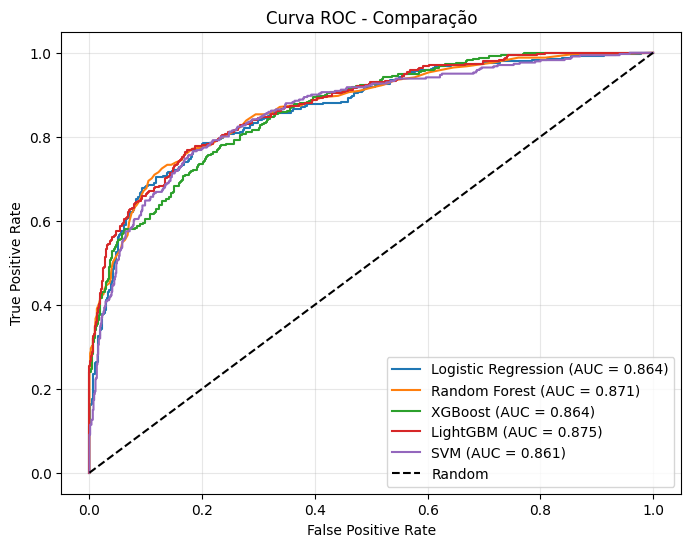

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Training Time (s)
0,Logistic Regression,0.836717,0.804470,0.789364,0.796206,0.864252,0.082231
1,Random Forest,0.836717,0.813451,0.771929,0.787915,0.870640,0.252497
2,LightGBM,0.835025,0.805591,0.779457,0.790482,0.875086,0.147552
3,SVM,0.827411,0.800124,0.761030,0.776063,0.860786,2.643485
4,XGBoost,0.810491,0.772779,0.750011,0.759561,0.864234,0.242408


In [13]:
# Evaluate models and get results
results_df = evaluate_models(X_train, X_test, y_train, y_test, preprocessor)
results_df

In [14]:
# Hyperparameter tuning models
param_grids = {
    "Logistic Regression": {
        "classifier__C": [0.001, 0.01, 0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"],
        "classifier__max_iter": [1000],
    },
    "Random Forest": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [10, 20, 30, None],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__max_features": ["sqrt", "log2"],
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__max_depth": [3, 6, 9],
        "classifier__min_child_weight": [1, 3, 5],
        "classifier__subsample": [0.8, 0.9, 1.0],
        "classifier__colsample_bytree": [0.8, 0.9, 1.0],
    },
    "LightGBM": {
        "classifier__n_estimators": [100],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__num_leaves": [31, 50],
        "classifier__max_depth": [-1, 10],
        "classifier__min_child_samples": [20, 50],
    },
}

In [15]:
def load_or_train_models(
    X_train, X_test, y_train, y_test, preprocessor, param_grids, models_dir="../models"
):
    """
    Loads existing models or trains new ones if necessary.

    Args:
        X_train, X_test, y_train, y_test: Training and test data
        preprocessor: Data preprocessor
        param_grids: Dictionary with parameter grids
        models_dir: Directory where models are/will be saved

    Returns:
        DataFrame with results and dictionary with models
    """

    # Create directory for models if it doesn't exist
    os.makedirs(models_dir, exist_ok=True)

    results = []
    best_models = {}

    print("\n🔍 Checking existing models...")

    for name in param_grids.keys():
        model_path = os.path.join(
            models_dir, f"{name.lower().replace(' ', '_')}_model.pkl"
        )
        results_path = os.path.join(
            models_dir, f"{name.lower().replace(' ', '_')}_results.pkl"
        )

        try:
            # Try to load existing model and results
            if os.path.exists(model_path) and os.path.exists(results_path):
                print(f"\n📂 Loding existing model: {name}")
                best_models[name] = joblib.load(model_path)
                model_results = joblib.load(results_path)
                results.append(model_results)

                print(f"✅ {name}:")
                print(f"   Best CV Score: {model_results['Best CV Score']:.4f}")
                print(f"   Test Accuracy: {model_results['Test Accuracy']:.4f}")

            else:
                print(f"\n⚙️ Training new model: {name}")
                # Create model instance
                if name == "Logistic Regression":
                    model = LogisticRegression(random_state=RANDOM_STATE)
                elif name == "Random Forest":
                    model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
                elif name == "XGBoost":
                    model = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
                elif name == "LightGBM":
                    model = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=2)

                # Create and train pipeline
                pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

                # Configure GridSearchCV
                grid = GridSearchCV(
                    pipe,
                    param_grid=param_grids[name],
                    cv=5,
                    scoring="accuracy",
                    n_jobs=-1,
                    verbose=1,
                )

                # Tain
                start_time = time.time()
                grid.fit(X_train, y_train)
                exec_time = time.time() - start_time

                # Evaluate
                y_pred = grid.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_pred)

                # Create results dictionary
                model_results = {
                    "Model": name,
                    "Best CV Score": grid.best_score_,
                    "Test Accuracy": test_accuracy,
                    "Best Parameters": grid.best_params_,
                    "Training Time (s)": exec_time,
                }

                results.append(model_results)
                best_models[name] = grid.best_estimator_

                # Save model and results
                joblib.dump(grid.best_estimator_, model_path)
                joblib.dump(model_results, results_path)

                print(f"✅ {name}:")
                print(f"   Best CV Score: {grid.best_score_:.4f}")
                print(f"   Test Accuracy: {test_accuracy:.4f}")
                print(f"   Time: {exec_time:.2f}s")
                print(f"   Model saved in: {model_path}")

        except Exception as e:
            print(f"❌ Error while processing {name}: {str(e)}")

    # Create DataFrame with results
    results_df = (
        pd.DataFrame(results)
        .sort_values(by="Test Accuracy", ascending=False)
        .reset_index(drop=True)
    )

    return results_df, best_models

In [16]:
# Execute the function to load or train models
results_df, best_models = load_or_train_models(
    X_train, X_test, y_train, y_test, preprocessor, param_grids
)


🔍 Checking existing models...

📂 Loding existing model: Logistic Regression
✅ Logistic Regression:
   Best CV Score: 0.8321
   Test Accuracy: 0.8384

📂 Loding existing model: Random Forest
✅ Random Forest:
   Best CV Score: 0.8533
   Test Accuracy: 0.8367

📂 Loding existing model: XGBoost
✅ XGBoost:
   Best CV Score: 0.8603
   Test Accuracy: 0.8376

📂 Loding existing model: LightGBM
✅ LightGBM:
   Best CV Score: 0.8535
   Test Accuracy: 0.8350


In [17]:
# Visualize the results
print("\n📊 Final Results:")
display(results_df)


📊 Final Results:


,Model,Best CV Score,Test Accuracy,Best Parameters,Training Time (s)
0,Logistic Regression,0.832132,0.838409,"{'classifier__C': 1, 'classifier__max_iter': 1...",7.224343
1,XGBoost,0.860287,0.837563,"{'classifier__colsample_bytree': 1.0, 'classif...",44.004476
2,Random Forest,0.853301,0.836717,"{'classifier__max_depth': 30, 'classifier__max...",94.257434
3,LightGBM,0.853514,0.835025,"{'classifier__learning_rate': 0.1, 'classifier...",6.116947


In [18]:
# Indetify the best model
best_model_name = results_df.iloc[0]["Model"]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")


🏆 Best Model: Logistic Regression
   Test Accuracy: 0.8384


In [31]:
def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluates model performance with visualization metrics
    
    Args:
        model: Trained model (Complete Pipeline)
        X_test: Test data
        y_test: Test labels
    """
    # Set plot style
    plt.style.use('ggplot')
    
    # Make predictions
    print("🎯 Making predictions...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Create figure with subplots - Curves
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    print("📈 Generating Performance Curves...")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    ax1.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='blue', linewidth=2)
    ax1.plot([0, 1], [0, 1], '--', color='gray', label='Random')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, label=f'AUC = {pr_auc:.3f}', color='red', linewidth=2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create figure for Confusion Matrix
    print("🎯 Generating Confusion Matrix...")
    fig2, ax3 = plt.subplots(figsize=(8, 6))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\n📊 Model Performance Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance for Logistic Regression
    clf = model.named_steps['classifier']
    if isinstance(clf, LogisticRegression):
        print("\n🔍 Feature Importance Analysis:")
        numeric_features = numeric_cols
        categorical_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names = np.concatenate([numeric_features, categorical_features])
        
        coefficients = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(clf.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 15 Most Important Features:")
        display(coefficients.head(15).reset_index(drop=True))
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=coefficients.head(15),
            x='Importance',
            y='Feature'
        )
        plt.title('Top 15 Most Important Features')
        plt.xlabel('Absolute Coefficient Value')
        plt.tight_layout()
        plt.show()



🔍 Evaluating Best Model: logistic_regression
🎯 Making predictions...
📈 Generating Performance Curves...


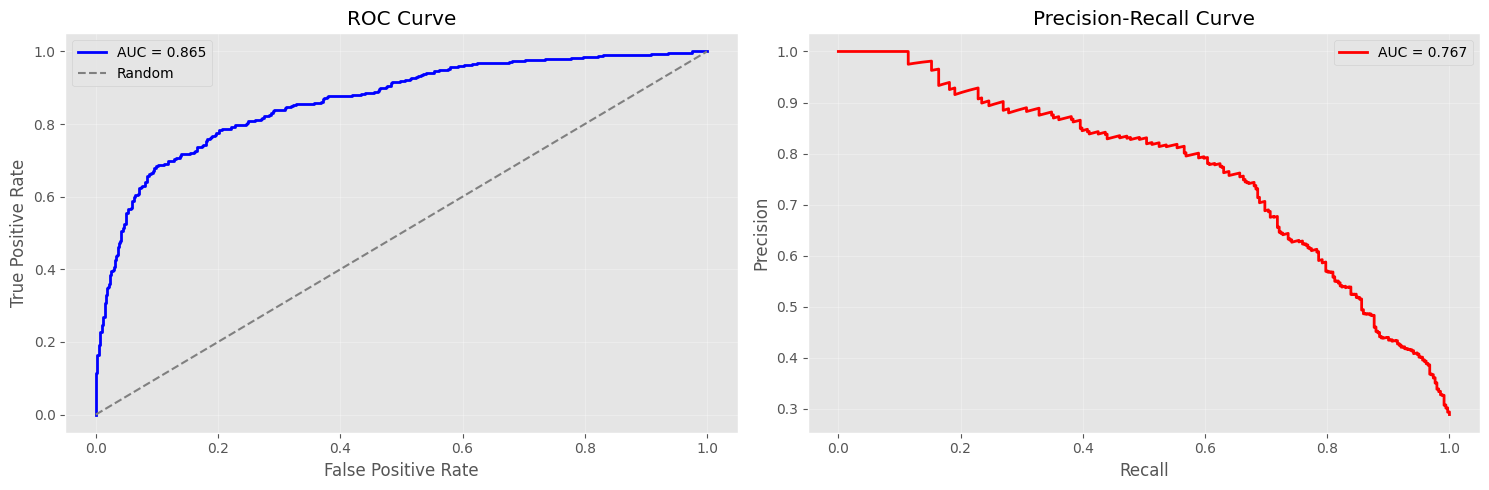

🎯 Generating Confusion Matrix...


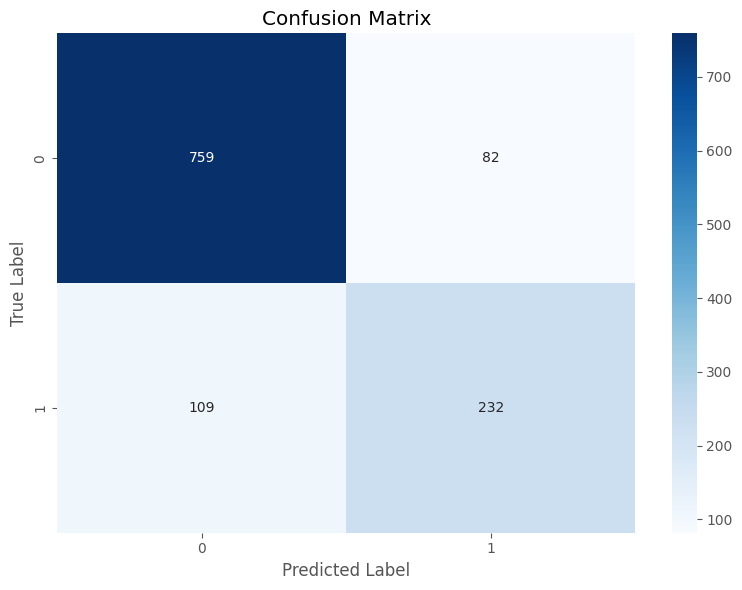


📊 Model Performance Metrics:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       841
           1       0.74      0.68      0.71       341

    accuracy                           0.84      1182
   macro avg       0.81      0.79      0.80      1182
weighted avg       0.84      0.84      0.84      1182


🔍 Feature Importance Analysis:

Top 15 Most Important Features:


,Feature,Importance
0,Contract_Two Year,2.871290
1,Monthly_Charge,2.037727
2,Phone_Service_Yes,1.470269
3,Contract_One Year,1.466164
4,Value_Deal_Deal 4,1.343720
5,Value_Deal_Deal 3,1.252347
6,Value_Deal_Deal 2,1.045141
7,State_Jammu & Kashmir,1.001364
8,State_Assam,0.847995
9,Internet_Type_Fiber Optic,0.847377


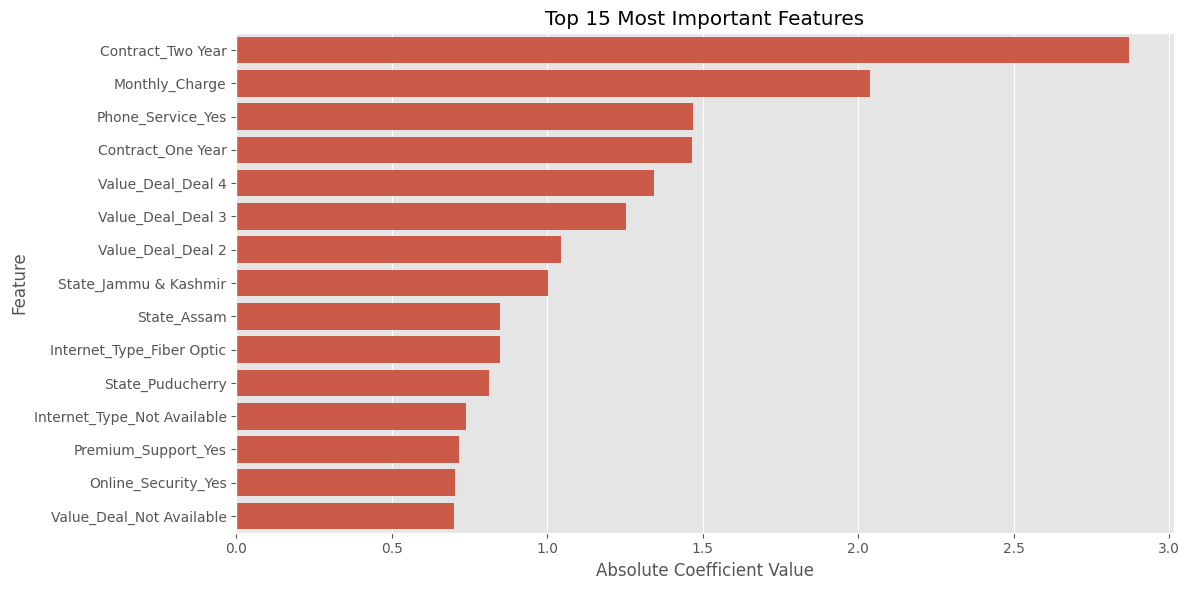

In [32]:
# Load and evaluate the best model
models_dir = "../models"
best_model_name = "logistic_regression"
model_path = os.path.join(models_dir, f"{best_model_name}_model.pkl")

print(f"\n🔍 Evaluating Best Model: {best_model_name}")
best_model = joblib.load(model_path)
evaluate_model_performance(best_model, X_test, y_test)